In [8]:
import numpy as np
import os, sys, time
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from iflow import model
from iflow.trainers import goto_dynamics_train
from iflow.utils import to_numpy, to_torch
from iflow.visualization import visualize_latent_distribution, visualize_vector_field, visualize_2d_generated_trj
from iflow.test_measures import log_likelihood, iros_evaluation
from iflow.dataset.generic_dataset import Dataset, CycleDataset
import matplotlib.pyplot as plt
from iflow.visualization import visualize_latent_distribution, visualize_vector_field, visualize_2d_generated_trj

In [121]:
percentage = .99
batch_size = 100
depth = 10
## optimization ##
lr = 0.001
weight_decay = 0.
## training variables ##
nr_epochs = 1000

dim = 2
device = torch.device('cpu')

In [122]:
#### Invertible Flow model #####
def main_layer(dim):
    return  model.CouplingLayer(dim)


def create_flow_seq(dim, depth):
    chain = []
    for i in range(depth):
        chain.append(main_layer(dim))
        chain.append(model.RandomPermutation(dim))
        chain.append(model.LULinear(dim))
    chain.append(main_layer(dim))
    return model.SequentialFlow(chain)

In [123]:
params = {'batch_size': batch_size, 'shuffle': True}
######### Model #########
dynamics = model.TanhStochasticDynamics(dim, dt=0.01, T_to_stable=2.5)
#dynamics = model.LinearStochasticDynamics(dim, dt=0.01, T_to_stable=2.5)
flow = create_flow_seq(dim, depth)
iflow = model.ContinuousDynamicFlow(dynamics=dynamics, model=flow, dim=dim).to(device)
########## Optimization ################
params = list(flow.parameters()) + list(dynamics.parameters())
optimizer = optim.Adamax(params, lr = lr, weight_decay= weight_decay)

In [144]:
import scipy.io
import pandas as pd
mat = scipy.io.loadmat('data/LASA_dataset/Sshape.mat', squeeze_me=True)

In [22]:
from iflow.dataset.lasa_dataset import LASA

In [23]:
data = LASA(filename = 'Sshape')

In [24]:
data.dataset.x.shape

torch.Size([20, 690, 2])

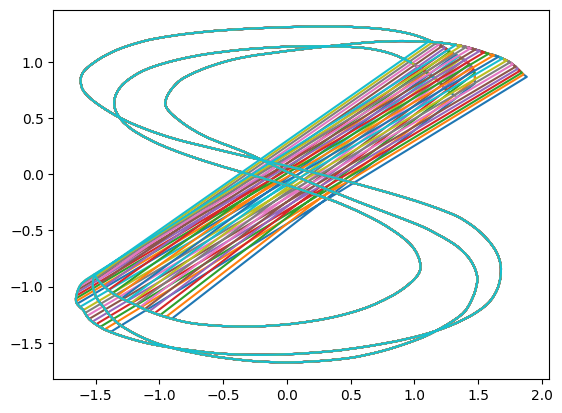

In [33]:
for i in range(20):
    plt.plot(data.dataset.x[i,:,0],data.dataset.x[i,:,1])

In [17]:
x.shape

(100, 2)

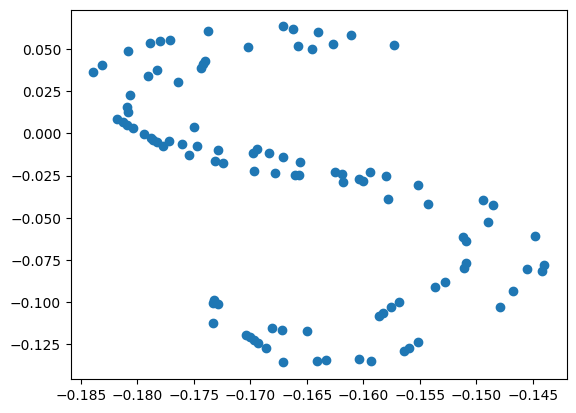

In [21]:
plt.scatter(x[:,1], x[:,0])

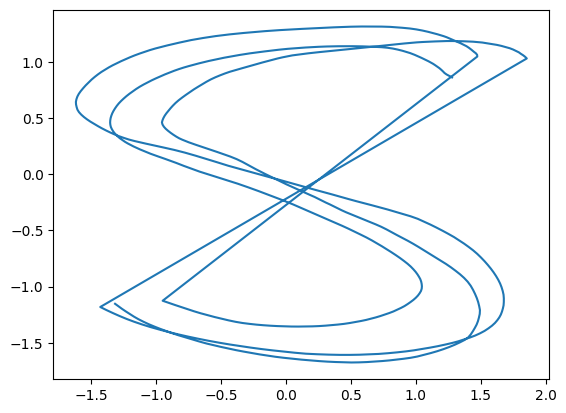

In [179]:
plt.plot(data.dataset.x[1,:,0],data.dataset.x[9,:,1])

In [125]:
mat["demos"][0][0]
trajs_real=[]
for demo_i in mat['demos']:
    x = demo_i[0]
    y = demo_i[1]
    tr_i = np.stack((x,y))
    trajs_real.append(tr_i.T)

In [143]:
len(trajs_real)

3

In [140]:
trajs_real[0].shape

(250, 2)

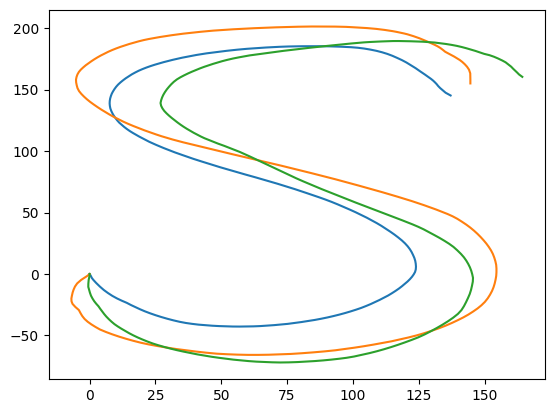

In [127]:
for i in range(3):
    plt.plot(*zip(*trajs_real[i]))

In [128]:
np.array(trajs_real).shape

(3, 250, 2)

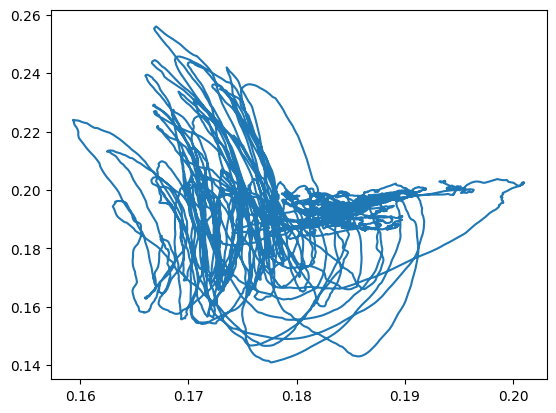

In [129]:
from data.human_robot_interaction_data.read_hh_hr_data import read_data
data_p, data_q, names, times = read_data("data/human_robot_interaction_data/hr/p1/hand_shake_s1_1.csv")
data_p[:,-3:-1,0]
plt.plot(data_p[:,-3,0],data_p[:,-2,0])

In [130]:
dataset = Dataset(trajs=trajs_real, device=device)
dataset = Dataset(trajs=data_p[:,-3:-1,0].reshape(1,23617, 2), device=device, steps=100)

In [131]:
data_p[:,-4:-1,0].reshape(1,23617, 3)

array([[[0.06110175, 0.1931954 , 0.2028845 ],
        [0.06110175, 0.1931954 , 0.2028845 ],
        [0.06110175, 0.1931954 , 0.2028845 ],
        ...,
        [0.05447701, 0.1862234 , 0.1960449 ],
        [0.05449808, 0.1862544 , 0.1960678 ],
        [0.05453649, 0.1863013 , 0.1961031 ]]])

In [132]:
params = {'batch_size': batch_size, 'shuffle': True}
dataloader = DataLoader(dataset, **params)

In [133]:
for i in range(100):
    for local_x, local_y in dataloader:
        dataloader.dataset.set_step()
        optimizer.zero_grad()
        loss = goto_dynamics_train(iflow, local_x, local_y)
        loss.backward(retain_graph=True)
        optimizer.step()
    visualize_2d_generated_trj(data_p[:,-3:-1,0].reshape(1,23617, 2), iflow, device=device, fig_number=2)

KeyboardInterrupt: 

In [ ]:
train_phase_data = []
for i in range(len(train_data)):
    trj = train_data[0]
    N = trj.shape[0]
    t = np.linspace(0,N*dt,N)
    phase_trj = np.arctan2(np.sin(w*t),np.cos(w*t))
    train_phase_data.append(phase_trj)

dataset = CycleDataset(trajs=train_data, device=device, trajs_phase=train_phase_data)

In [ ]:
import numpy as np

In [ ]:
drums_data = np.load('/Users/arnebackstein/PycharmProjects/iflow/data/DRUMS_dataset/Drums.npy')

In [ ]:
from iflow.dataset import drums_dataset

In [ ]:
data = drums_dataset.DRUMS()

In [ ]:
for i in range(6):
    plt.plot(data.dataset.x[6,:,i])

In [ ]:
drums_data.shape

In [ ]:
data_p.shape

In [ ]:
data_p.shape

In [ ]:
ax = plt.axes(projection='3d')
i = -1
# Data for a three-dimensional line
xline = data_p[:,i,0]
yline = data_p[:,i,1]
zline = data_p[:,i,2]
ax.plot3D(zline, -yline, xline)

In [ ]:
plt.plot(data_p[:,-1,0],data_p[:,-1,1])

In [ ]:
data_p[::25,-4:-1,:].shape

In [ ]:
names

In [ ]:
plt.plot(data_p[::25,-5:-1,2])

In [ ]:
plt.plot(drums_data[0])

In [ ]:
data_p[::25,-7:-1,0,].shape

In [ ]:
train_data = data_p[::25,-7:-1,0,].reshape(1,945, 6)

In [ ]:
np.save('/Users/arnebackstein/PycharmProjects/iflow/data/newDataTest/data.npy', train_data)

In [ ]:
from iflow.dataset.testing_dataset import TESTDATA

In [ ]:
dataset = TESTDATA()

In [ ]:
dataset.train_data[0].shape

In [ ]:
names

In [ ]:
import numpy as np
from data.human_robot_interaction_data.read_hh_hr_data import *
import os
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import grid_sample, affine_grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
src_dir = 'data/human_robot_interaction_data/hr'
actions = ['hand_wave', 'hand_shake', 'rocket', 'parachute']
idx_list = np.array([joints_dic[joint] for joint in ['RightShoulder', 'RightArm', 'RightForeArm', 'RightHand']])

In [ ]:
for action in actions:
	data_h, data_r = read_hri_data(action, src_dir = src_dir)
	seq_len, _, dims = data_h.shape
	data_h = data_h[:, idx_list].reshape((-1, len(idx_list)*dims))
	segments_file_h = os.path.join(src_dir, 'segmentation', action+'_p1.npy')
	segments_file_r = os.path.join(src_dir, 'segmentation', action+'_r2.npy')
	segments_h = np.load(segments_file_h)
	segments_r = np.load(segments_file_r)

	for i in range(len(segments_h)):
		s_h = segments_h[i]
		s_r = segments_r[i]
		ax1 = plt.subplot(211)
		ax2 = plt.subplot(212)
		for dim in range(len(data_h.T)):
			ax1.plot(data_h[s_h[0]:s_h[1], dim])
		for dim in range(len(data_r.T)):
			ax2.plot(data_r[s_r[0]:s_r[1], dim])
		plt.show()
